In [43]:
#Ensuring compliance of code with both python2 and python3

from __future__ import division, print_function
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based
#sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [54]:
problem = {
  'num_vars': 7,
  'names': ['random-seed',
            'initial-yearly-government-subsidy',
            'initial-fraction-subsidy-to-pora',
            'capacity-threshold-extensible',
            'additional-subsidy',
            'subsidy-fraction-change',
            'initial-electricity-price'],
  'bounds': [[1, 100000],
             [0, 200],
             [0, 1],
             [0, 1],
             [0,20],
             [0,1],
             [-0.005,0.005]]
}

In [55]:
n = 1000
param_values = saltelli.sample(problem, n, calc_second_order=True)

In [56]:
param_values.shape

(16000, 7)

In [57]:
import ipyparallel

In [58]:
client = ipyparallel.Client()
client.ids

[0, 1, 2, 3]

In [59]:
direct_view = client[:]

In [60]:
import os

#Push the current working directory of the notebook to a "cwd" variable on the engines that can be accessed later
direct_view.push(dict(cwd=os.getcwd()))

<AsyncResult: _push>

In [61]:
#Push the "problem" variable from the notebook to a corresponding variable on the engines
direct_view.push(dict(problem=problem))

<AsyncResult: _push>

In [62]:
%%px

import os
os.chdir(cwd)

import pyNetLogo
import pandas as pd

netlogo = pyNetLogo.NetLogoLink(gui=False)
netlogo.load_model('./models/Project.nlogo')

In [63]:
import jpype
jpype.get_default_jvm_path()

'/Library/Java/JavaVirtualMachines/jdk-11.0.2.jdk/Contents/Home/lib/jli/libjli.dylib'

In [64]:
def simulation(experiment):

    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(experiment[i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, experiment[i]))

    netlogo.command('setup')
    #Run for 31 ticks and report KPI's at each time step
    counts = netlogo.repeat_report(['percentage-of-CO2-captured',
                                    'total-co2-storage-industry-costs',
                                    'dispatched-subsidy-industry',
                                    'not-enough-money-counter',
                                    'dispatched-subsidy-infrastructure',
                                    'electricity-used',
                                    'total-co2-stored',
                                    'total-co2-emitted'], 31)

    results = pd.Series([counts['percentage-of-CO2-captured'].values[-1],
                         counts['total-co2-storage-industry-costs'].values[-1],
                         counts['dispatched-subsidy-industry'].values[-1],
                         counts['not-enough-money-counter'].values[-1],
                         counts['dispatched-subsidy-infrastructure'].values[-1],
                         counts['electricity-used'].values[-1],
                         counts['total-co2-stored'].values[-1],
                         counts['total-co2-emitted'].values[-1]],
                         index=['percentage-of-CO2-captured',
                                'total-co2-storage-industry-costs',
                                'dispatched-subsidy-industry',
                                'not-enough-money-counter',
                                'dispatched-subsidy-infrastructure',
                                'electricity-used',
                                'total-co2-stored',
                                'total-co2-emitted'])

    return results

In [65]:
lview = client.load_balanced_view()

results = pd.DataFrame(lview.map_sync(simulation, param_values))

In [66]:
results

,percentage-of-CO2-captured,total-co2-storage-industry-costs,dispatched-subsidy-industry,not-enough-money-counter,dispatched-subsidy-infrastructure,electricity-used,total-co2-stored,total-co2-emitted
0,12.038504,4904.004804,9.309196,20.0,1783.551674,1.739894e+11,1294.38,9457.62
1,7.774970,4831.416804,9.309196,20.0,1783.551674,1.370902e+11,1052.42,12483.58
2,17.439360,5039.285436,48.238564,13.0,3563.880272,2.658994e+11,1875.08,8876.92
3,13.900298,4955.372738,17.995262,20.0,1773.763885,2.691494e+11,1494.56,9257.44
4,12.038504,4904.004804,9.309196,20.0,1783.551674,1.739894e+11,1294.38,9457.62
5,12.038504,4904.004804,9.309196,20.0,1670.309486,1.739894e+11,1294.38,9457.62
6,11.027530,4871.394804,9.309196,20.0,1773.922081,1.631370e+11,1185.68,9566.32
7,12.038504,4904.004804,9.309196,20.0,1783.551674,1.739894e+11,1294.38,9457.62
8,11.975632,4818.037823,93.248177,16.0,3096.736908,1.814462e+11,1287.62,9464.38
9,7.649527,4817.636738,17.995262,20.0,1600.871086,1.348828e+11,1035.44,12500.56


In [68]:
results.to_csv('./data1/results.csv')
pd.DataFrame(param_values).to_csv('./data1/parameter_values.csv')

In [69]:
df = pd.DataFrame(param_values)

In [38]:
results

,percentage-of-CO2-captured,total-co2-storage-industry-costs,dispatched-subsidy-industry,not-enough-money-counter,dispatched-subsidy-infrastructure,electricity-used,total-co2-stored,total-co2-emitted
0,18.648158,3585.362727,30.546875,9.0,744.881287,3.788142e+11,1401.530000,5288.960000
1,17.378103,3516.690970,30.546875,15.0,1429.568787,3.319040e+11,1444.775000,7860.777685
2,16.572266,3504.503294,111.406250,1.0,476.581306,4.030390e+11,1344.355000,5281.365000
3,11.429967,3585.362272,30.546875,3.0,197.816315,4.119570e+11,946.575000,5262.860000
4,18.648158,3585.362727,30.546875,9.0,744.881287,3.788142e+11,1401.530000,5288.960000
5,11.429967,3586.377897,29.531250,3.0,197.136612,4.119570e+11,946.575000,5262.860000
6,16.791295,3591.358612,24.550858,5.0,335.524559,3.732898e+11,1269.135000,5569.325000
7,18.648158,3585.362727,30.546875,9.0,744.881287,3.788142e+11,1401.530000,5288.960000
8,24.711217,3505.519192,110.390625,17.0,2703.019867,2.981498e+11,1617.090000,6364.890000
9,17.275044,3517.706348,29.531250,17.0,1473.769054,2.928633e+11,1197.815000,8134.549805


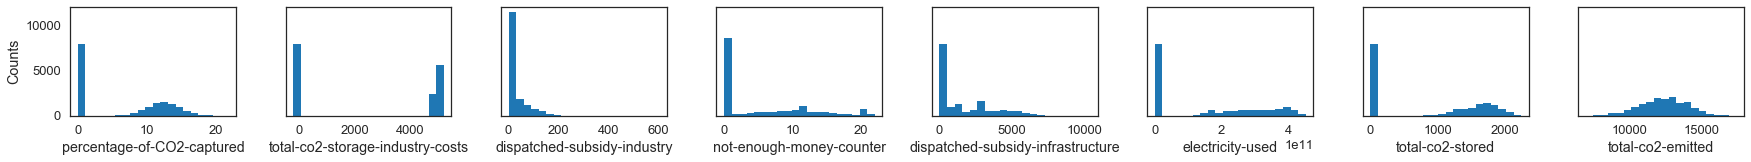

In [70]:
fig, ax = plt.subplots(1,len(results.columns), sharey=True)

for i, n in enumerate(results.columns):
    ax[i].hist(results[n], 20)
    ax[i].set_xlabel(n)
ax[0].set_ylabel('Counts')

fig.set_size_inches(30,2)
fig.subplots_adjust(wspace=0.3)

plt.show()

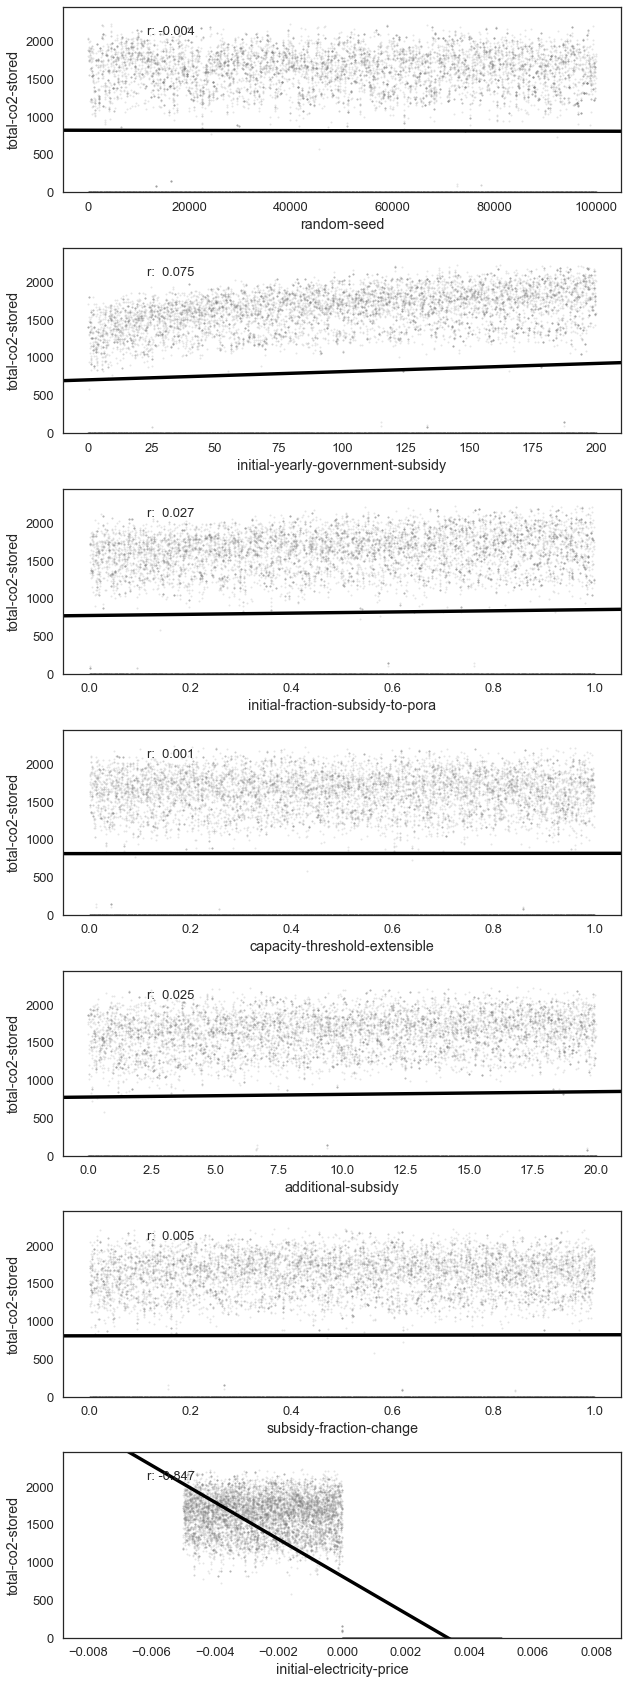

In [71]:
import scipy

nrow=7
ncol=1

fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = results['total-co2-stored']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(10,30,forward=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

In [72]:
Si = sobol.analyze(problem, results['percentage-of-CO2-captured'].values, calc_second_order=True, print_to_console=False)

In [73]:

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])



In [74]:
Si_df

,ST,ST_conf,S1,S1_conf
random-seed,0.048986,0.005965,0.026235,0.019988
initial-yearly-government-subsidy,0.021634,0.004241,0.009020,0.013618
initial-fraction-subsidy-to-pora,0.012542,0.002604,0.008368,0.010411
capacity-threshold-extensible,0.000000,0.000000,0.000000,0.000000
additional-subsidy,0.004197,0.001069,0.003666,0.005337
subsidy-fraction-change,0.003467,0.001400,0.004225,0.004929
initial-electricity-price,0.951060,0.070107,0.934657,0.064210


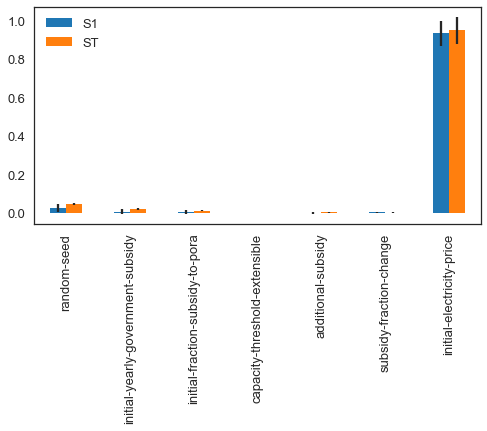

In [75]:
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()



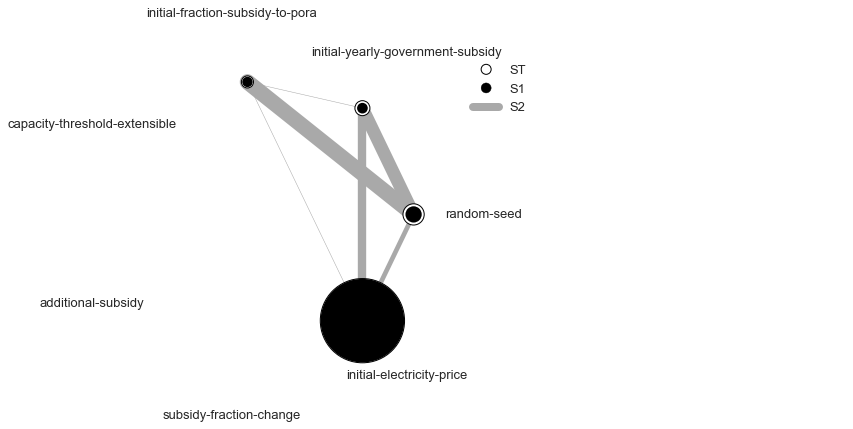

In [76]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.show()